In [1]:
import glob
import os
import pandas as pd
import numpy as np
import tqdm as tqdm
import itertools

from matplotlib import gridspec
import matplotlib.pyplot as plt
import seaborn as sns

# Positive selection of HLA-I genes across cancer types

In [2]:
df_mut_hmf = pd.read_csv("../../results/data/MUT_positive_selection_HMF.tsv",sep="\t") # Parsed using the parse_dNdScv.ipynb
df_mut_hmf["n_obs"] = df_mut_hmf["n_mis"] +  df_mut_hmf["n_non"] +  df_mut_hmf["n_spl"] +  df_mut_hmf["n_ind"] 
df_mut_pcawg = pd.read_csv("../../results/data/MUT_positive_selection_PCAWG.tsv",sep="\t") # Parsed using the parse_dNdScv.ipynb
df_mut_pcawg["n_obs"] = df_mut_pcawg["n_mis"] +  df_mut_pcawg["n_non"] +  df_mut_pcawg["n_spl"] +  df_mut_pcawg["n_ind"] 

df_cnv_hmf = pd.read_csv("../../results/data/CNV_positive_selection_HMF.tsv",sep="\t") # Parsed using the parse_CNVs.ipynb
df_cnv_pcawg = pd.read_csv("../../results/data/CNV_positive_selection_PCAWG.tsv",sep="\t") # Parsed using the parse_CNVs.ipynb

df_total = pd.read_csv("../metadata/dataset_metadata_supp_table3.tsv",sep="\t") # Metadata

In [3]:
# hartwig
muts=df_mut_hmf[["gene_name","qglobal_cv","ttype","n_obs"]].rename(columns={"qglobal_cv":"qvalue"})
muts["type_alteration"] = "mutation"
cnv=df_cnv_hmf[["gene","ttype","q_value_ana_global","type_alteration","n_obs"]].rename(columns={"gene":"gene_name","q_value_ana_global":"qvalue"})
df_hmf=pd.concat([muts,cnv])
# pcawg
muts=df_mut_pcawg[["gene_name","qglobal_cv","ttype","n_obs"]].rename(columns={"qglobal_cv":"qvalue"})
muts["type_alteration"] = "mutation"
cnv=df_cnv_pcawg[["gene","ttype","q_value_ana_global","type_alteration","n_obs"]].rename(columns={"gene":"gene_name","q_value_ana_global":"qvalue"})
df_pcawg=pd.concat([muts,cnv])


# MHC-I alterations

In [4]:
genes = ["HLA-A","HLA-B","HLA-C"]
order=sorted(list(set(df_hmf[df_hmf["gene_name"].isin(genes)]["ttype"].values)))
alterations = ["mutation","loh","deepdel","amp"]

### Hartwig

In [5]:
pivot=df_hmf.pivot_table(index=["ttype","type_alteration"],columns="gene_name",values=["qvalue","n_obs"])
counts = df_total[(df_total["is_selected"]==True)&(df_total["cohort"]=="HMF")]["cancer_type"].value_counts()
counts["pancancer"] = df_total[(df_total["is_selected"]==True)&(df_total["cohort"]=="HMF")].shape[0]
codes=df_total[(df_total["is_selected"]==True)][["cancer_type","cancer_type_code"]].drop_duplicates().set_index("cancer_type").to_dict()["cancer_type_code"]
codes["pancancer"] = "PANCAN"
d_colors = {"loh": "#a8ddb5", "deepdel": "#43a2ca", "amp": "#de2d26","mutation":"grey"}

In [6]:
markers={"mutation":"o","loh":"s","deepdel":"X","amp":"P"}
offset_x={"mutation":0,"loh":0,"deepdel":0,"amp":0}
offset_y={"mutation":0,"loh":0,"deepdel":0,"amp":0}
def get_lw(df,ttype,talt,gene):
    if talt=="mutation":
        return 0.5
    q=df[(df["ttype"]==ttype)&(df["type_alteration"]==talt)&(df["gene"]==gene)]
    if q.shape[0] == 0:
        return 0
    for v in str(q["focal"].values[0]).split(","):
        if "hfocal" == v:
            return 2
        if "focal" ==  v:
            return 0.75
    return 0

### Plot

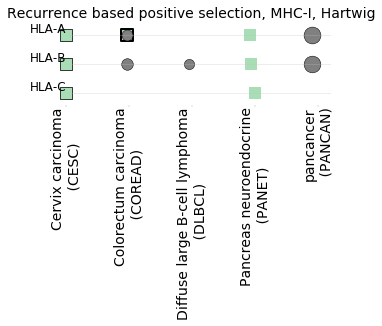

In [7]:
N=len(order)
fig,ax=plt.subplots(figsize=(N*1,len(genes)/2))

gs = gridspec.GridSpec(ncols=1,nrows=len(genes),wspace=0.0)
axis=[]
for j, gene in enumerate(genes):
    ax = plt.subplot(gs[j]) 
    ax.get_xaxis().set_visible(False)
    for i,ttype_s in enumerate(order):
        ttype_s=order[i]
        for k,talt in enumerate(["loh","mutation","deepdel","amp"]):
            marker=markers[talt]
            if (ttype_s,talt) in pivot.index:
                qvalues=-np.log10([10**-20 +x for x in  pivot.loc[(ttype_s,talt)][list(itertools.product(["qvalue"],[gene]))].values])
                colors=d_colors[talt]
                sizes=[s**1.3+100 if np.isfinite(s) else 0 for s in pivot.loc[(ttype_s,talt)][list(itertools.product(["n_obs"],[gene]))].values]
                lw=[get_lw(df_cnv_hmf,ttype_s,talt,g) for g in [gene] ]
                edgecolors="black"
                ax.scatter(x=[i for x in range(0,len(qvalues))],y=[0 for x in range(0,len(qvalues))],s=sizes,color=colors,edgecolors=edgecolors,linewidths=lw,clip_on=False,marker=marker)
    ax.spines["top"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.set_xticks([])
    ax.axhline(y=0,xmin=0.05,xmax=1.1,color="#C0C0C0",lw=0.55,alpha=0.5)
    ax.set_ylabel(gene,fontsize=12,rotation=0)
    #ax.set_ylabel(,fontsize=12,rotation=0,verticalalignment="center", labelpad=100)
    ax.set_yticks([])
    ax.set_xlabel("")
    
    axis.append(ax)

ax.spines["top"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["bottom"].set_visible(False)
ax.get_xaxis().set_visible(True)
ax.set_xticks(list(range(0,len(order))))
ax.set_xticklabels([ttype_s.replace("__"," ") + "\n ("+codes[ttype_s.replace("__"," ")]+")" for ttype_s in order],rotation=90)
ax.tick_params(axis = 'both', labelsize =14  , pad=0.15,width=0.15, length = 1.5)
axis[0].set_title("Recurrence based positive selection, MHC-I, Hartwig",fontsize=14)

plt.savefig("../results/figures/figure3/positive_selection_hmf_mhcI.pdf", dpi=800,bbox_inches="tight")
plt.show()


# PCAWG

In [8]:
genes = ["HLA-A","HLA-B","HLA-C"]
order=sorted(list(set(df_pcawg[df_pcawg["gene_name"].isin(genes)]["ttype"].values)))
alterations = ["mutation","loh","deepdel","amp"]

In [9]:
order

['Diffuse__large__B-cell__lymphoma',
 'Kidney__chromophobe__cancer',
 'Pancreas__neuroendocrine',
 'pancancer']

In [10]:
pivot=df_pcawg.pivot_table(index=["ttype","type_alteration"],columns="gene_name",values=["qvalue","n_obs"])
counts = df_total[(df_total["is_selected"]==True)&(df_total["cohort"]=="PCAWG")]["cancer_type"].value_counts()
counts["pancancer"] = df_total[(df_total["is_selected"]==True)&(df_total["cohort"]=="PCAWG")].shape[0]
codes=df_total[(df_total["is_selected"]==True)][["cancer_type","cancer_type_code"]].drop_duplicates().set_index("cancer_type").to_dict()["cancer_type_code"]
codes["pancancer"] = "PANCAN"
codes["Kidney chromophobe cancer"] = "KICH"
d_colors = {"loh": "#a8ddb5", "deepdel": "#43a2ca", "amp": "#de2d26","mutation":"grey"}

### Plot

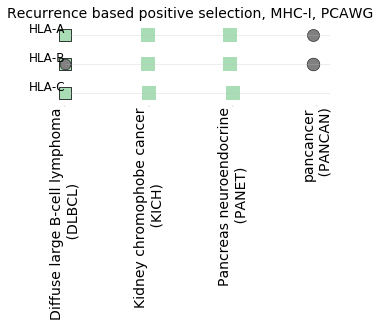

In [11]:
fig,ax=plt.subplots(figsize=(N*1,len(genes)/2))
N=len(order)
gs = gridspec.GridSpec(ncols=1,nrows=len(genes),wspace=0.0)
axis=[]
for j, gene in enumerate(genes):
    ax = plt.subplot(gs[j]) 
    ax.get_xaxis().set_visible(False)
    for i,ttype_s in enumerate(order):
        ttype_s=order[i]
        for k,talt in enumerate(["loh","mutation","deepdel","amp"]):
            marker=markers[talt]
            if (ttype_s,talt) in pivot.index:
                qvalues=-np.log10([10**-20 +x for x in  pivot.loc[(ttype_s,talt)][list(itertools.product(["qvalue"],[gene]))].values])
                colors=d_colors[talt]
                sizes=[s**1.3+100 if np.isfinite(s) else 0 for s in pivot.loc[(ttype_s,talt)][list(itertools.product(["n_obs"],[gene]))].values]
                lw=[get_lw(df_cnv_pcawg,ttype_s,talt,g) for g in [gene] ]
                edgecolors="black"
                ax.scatter(x=[i for x in range(0,len(qvalues))],y=[0 for x in range(0,len(qvalues))],s=sizes,color=colors,edgecolors=edgecolors,linewidths=lw,clip_on=False,marker=marker)
    ax.spines["top"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.set_xticks([])
    ax.axhline(y=0,xmin=0.05,xmax=1.1,color="#C0C0C0",lw=0.55,alpha=0.5)
    ax.set_ylabel(gene,fontsize=12,rotation=0)
    #ax.set_ylabel(,fontsize=12,rotation=0,verticalalignment="center", labelpad=100)
    ax.set_yticks([])
    ax.set_xlabel("")
    
    axis.append(ax)

ax.spines["top"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["bottom"].set_visible(False)
ax.get_xaxis().set_visible(True)
ax.set_xticks(list(range(0,len(order))))
ax.set_xticklabels([ttype_s.replace("__"," ") + "\n ("+codes[ttype_s.replace("__"," ")]+")" for ttype_s in order],rotation=90)
ax.tick_params(axis = 'both', labelsize =14  , pad=0.15,width=0.15, length = 1.5)
axis[0].set_title("Recurrence based positive selection, MHC-I, PCAWG",fontsize=14)

plt.savefig("../results/figures/figure3/positive_selection_pcawg_mhcI.pdf", dpi=800,bbox_inches="tight")
plt.show()


### Select plots of CNV positive selection examples

##### Pancreas neuroendocrine in Hartwig

In [12]:
!cp /home/fran/Documents/cuppen/HPC/tunnel/cuppen/projects/P0020_genetics_immune_escape/large_scale_primary_met/processed/hmf/positive_selection/cnv/ignore_loh_nonfocal/plots/Pancreas__neuroendocrine_ignore_loh_nonfocal.pdf ../../results/figures/figure3/

##### Colorectal hfocal in Hartwig

In [13]:
!cp /home/fran/Documents/cuppen/HPC/tunnel/cuppen/projects/P0020_genetics_immune_escape/large_scale_primary_met/processed/hmf/positive_selection/cnv/ignore_loh_hfocal/plots/Colorectum__carcinoma_ignore_loh_hfocal_zoom.pdf ../../results/figures/figure3/

##### Cervix focal in Hartwig

In [14]:
!cp /home/fran/Documents/cuppen/HPC/tunnel/cuppen/projects/P0020_genetics_immune_escape/large_scale_primary_met/processed/hmf/positive_selection/cnv/ignore_loh_focal/plots/Cervix*.pdf ../../results/figures/figure3/

##### Kidney chromophobe nonfocal in PCAWG

In [15]:
!cp /home/fran/Documents/cuppen/HPC/tunnel/cuppen/projects/P0020_genetics_immune_escape/large_scale_primary_met/processed/pcawg/positive_selection/cnv/ignore_loh_nonfocal/plots/Kidney__chromophobe__cancer_ignore_loh_nonfocal*.pdf  ../../results/figures/figure3/